# Robot Manipulation Object Classification - Model Training

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datasets import load_dataset
#scaling the data
from sklearn.preprocessing import StandardScaler
#Spliting Data
from sklearn.model_selection import train_test_split
#Logistic regression
from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm
# Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
#gb/rf comparisson
from sklearn.metrics import zero_one_loss
from sklearn.metrics import roc_auc_score
#SVM
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report,
    make_scorer, roc_auc_score
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

## Construct Data Frame:
1. Import the data
2. Construct data frame with following features:
 -  Mean statistic of 'Action' vector's 5-15 dimensions
 -  Episode Length
 -  Gripper Motion Time (Dim_15 > 0)
3. Scale the feature  - All features are normalized with $\mu$ = 0 and $\sigma^2$ = 1

In [5]:
# Appload Raw Data
df_full = pd.read_csv("C:/Users/danar/OneDrive/Desktop/Studies/MSc/Semester B/Statistical Lerning/project/RawData_PickPlace.csv")

episode_features = []

# Selected dimensions
selected_dims = [5,6,7,8,9,10,11,12,13,14,15]

# Threshold for motion detection
motion_threshold = 1e-4

#Group by episode
for ep_id, group in df_full.groupby("episode_id_global"):
    group = group.sort_values("frame_idx")
    row = {
        "episode_id": ep_id,
        "task": group["task"].iloc[0],
    }

    # Initialize motion flags
    motion_flags = pd.Series([False] * len(group), index=group.index)

    for dim in selected_dims:
        dim_col = f"dim_{dim}"
        dim_values = group[dim_col]

        row[f"{dim_col}_mean"] = dim_values.mean()

        if dim == 15:
            # Calculate motion features for dimension 15 only
            motion_flags = dim_values.abs() > motion_threshold
            gripper_motion_time = motion_flags.sum()
            episode_length = len(group)

            row["gripper_motion_time"] = gripper_motion_time
            row["episode_length"] = episode_length

    episode_features.append(row)
#Create Data frame
df_episode = pd.DataFrame(episode_features)
#Create binary labels for 'pick' and 'place'
df_episode["task_label"] = df_episode["task"].apply(lambda x: 0 if x == "pick" else 1)

#Scale Data
#Separate label and metadata
metadata_cols = ["episode_id", "task", "task_label"]
feature_cols = [col for col in df_episode.columns if col not in metadata_cols]

#Scale only the feature columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_episode[feature_cols])

#Rebuild the DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=feature_cols)
df_scaled[metadata_cols] = df_episode[metadata_cols].reset_index(drop=True)

# reorder columns - Final DF
df_scaled = df_scaled[metadata_cols + feature_cols]
df_scaled.head()

,episode_id,task,task_label,dim_5_mean,dim_6_mean,dim_7_mean,dim_8_mean,dim_9_mean,dim_10_mean,dim_11_mean,dim_12_mean,dim_13_mean,dim_14_mean,dim_15_mean,gripper_motion_time,episode_length
0,0,pick,0,0.361058,-0.699614,2.009816,-0.454436,-0.352760,-0.539475,-1.079916,-0.858035,0.797187,-0.276606,-0.983744,-0.709683,-0.123887
1,1,pick,0,-0.484315,0.022850,0.006672,0.019461,-0.245732,-0.067227,0.196897,0.091192,0.569279,0.288621,-0.762457,-0.735656,-0.851399
2,2,pick,0,-1.838721,-0.624531,0.964328,0.039934,-0.800404,0.137992,1.923198,0.015741,-0.541440,-0.082030,-0.656983,-0.406674,-0.148137
3,3,pick,0,0.495539,0.586235,-0.198191,0.108828,-0.226361,-0.300060,-0.094512,0.111436,0.924604,0.519076,-0.485791,-0.579822,-0.382558
4,4,pick,0,-0.058324,0.027493,-0.253538,-0.165205,-0.681003,-0.025164,0.630139,-0.233091,0.586306,0.096234,-0.866188,-0.752970,-0.819065


## Create Train and Test Splits
 -  Test size - 20% of data
 -  'stratify' keeps balance between 'pick', 'place bench' and 'place cabinet' tasks


In [6]:

#Split to train and test, test size 20% (keep balance between pick, place bench, place cabinet)
X = df_scaled.drop(columns=["episode_id", "task", "task_label"]) 
y = df_scaled["task_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_scaled["task"]
)

## Train Models

### Logistic Regression - Lasso - $\ell 1$ penalty

Lasso (L1) regularization enhances model sparsity by shrinking coefficients of less important features to zero, which improves interpretability and reduces overfitting, especially in high-dimensional settings.

We used LogisticRegressionCV with 5-fold cross-validation, selecting the regularization strength $C = 1/\lambda$ to maximize F1 score.

Results show that there is explanatory dominance to Dimension 15 mean (gripper).

In [6]:


# Lasso = L1 penalty
lasso_model = LogisticRegressionCV(
    Cs=10,                         # Number of inverse regularization values to try
    cv=5,                          # 5-fold cross-validation
    penalty='l1',                  # Lasso
    solver='liblinear',           # Supports L1 penalty
    scoring='f1',                  # or 'accuracy', 'roc_auc'
    class_weight='balanced',       # for imbalanced classes
    random_state=42,
    max_iter=1000
)

lasso_model.fit(X_train, y_train)

print("Best C:", lasso_model.C_[0])  # Inverse of regularization strength
print("Coefficients:")
for name, coef in zip(X.columns, lasso_model.coef_[0]):
    print(f"{name}: {coef:.4f}")

Best C: 2.782559402207126
Coefficients:
dim_5_mean: 1.1227
dim_6_mean: -1.7332
dim_7_mean: -1.8432
dim_8_mean: 0.3358
dim_9_mean: -0.0379
dim_10_mean: 0.0000
dim_11_mean: 1.5280
dim_12_mean: -0.3909
dim_13_mean: 0.8561
dim_14_mean: 0.2630
dim_15_mean: 7.6439
gripper_motion_time: 1.4538
episode_length: -0.9415


### Logistic Regression  - Model Selection By StepAIC 

Stepwise regression based on the Akaike Information Criterion (AIC) selects features iteratively by balancing model fit and complexity. We used forward selection via statsmodels to identify a compact set of predictors.

Once again we observe the dominance of Dim_15_mean. In addition we note that there is a risk of overfitting due to quasi-Separation.

In [7]:
# stepAIC



# ---------- STEPWISE AIC FUNCTION (for binary classification) ----------
def forward_selection(X, y):
    remaining = list(X.columns)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    best_model = None

    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            try:
                features = selected + [candidate]
                X_candidate = sm.add_constant(X[features])
                model = sm.Logit(y, X_candidate).fit(disp=0)  # ✅ Binary logistic regression
                aic = model.aic
                scores_with_candidates.append((aic, candidate, model))
            except:
                continue

        if not scores_with_candidates:
            break

        scores_with_candidates.sort()
        best_new_score, best_candidate, candidate_model = scores_with_candidates[0]

        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            best_model = candidate_model
        else:
            break

    return best_model, selected

# ---------- RUN STEPWISE SELECTION ----------
final_model, selected_features = forward_selection(X_train, y_train)

# ---------- SHOW RESULTS ----------
print("✅ Selected features:", selected_features)
print("📉 Final AIC:", final_model.aic)
print(final_model.summary())

✅ Selected features: ['dim_15_mean', 'dim_6_mean', 'dim_7_mean', 'dim_11_mean', 'dim_5_mean', 'dim_13_mean', 'episode_length']
📉 Final AIC: 71.07678460578838
                           Logit Regression Results                           
Dep. Variable:             task_label   No. Observations:                  432
Model:                          Logit   Df Residuals:                      424
Method:                           MLE   Df Model:                            7
Date:                Fri, 27 Jun 2025   Pseudo R-squ.:                  0.9080
Time:                        12:47:16   Log-Likelihood:                -27.538
converged:                       True   LL-Null:                       -299.43
Covariance Type:            nonrobust   LLR p-value:                3.057e-113
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.2026      0.607      3.

### Model Performance Comparison - Lasso/AIC

 -  Both Lasso and Stepwise logistic regression achieved excellent predictive results
 -  Lasso yielded more features but offered strong regularization and generalization
 -  Stepwise AIC minimized complexity while maintaining performance
 -  Over all Lasso performance is slightly better, but comes with less risk of overfitting.

In [8]:
#test for regression models
# Stepwise model used these features:
selected_features = ['dim_5_mean', 'dim_6_mean','dim_7_mean','dim_11_mean','dim_13_mean','dim_15_mean', 'gripper_motion_time', 'episode_length']

X_selected = sm.add_constant(X[selected_features])
final_model = sm.Logit(y, X_selected).fit()
# Test data subset for stepwise model (with constant)
X_test_step = sm.add_constant(X_test[selected_features])

# Full X_test already matches features used in Lasso model

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score, confusion_matrix, classification_report
)

# Predict class probabilities and labels
y_prob_step = final_model.predict(X_test_step)
y_pred_step = (y_prob_step > 0.5).astype(int)

print("🟢 Stepwise AIC Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_step))
print("F1 Score:", f1_score(y_test, y_pred_step))
print("ROC AUC:", roc_auc_score(y_test, y_prob_step))
print("Precision:", precision_score(y_test, y_pred_step))
print("Recall:", recall_score(y_test, y_pred_step))
print(confusion_matrix(y_test, y_pred_step))
print(classification_report(y_test, y_pred_step))

# Predict probabilities and labels
y_prob_lasso = lasso_model.predict_proba(X_test)[:, 1]
y_pred_lasso = lasso_model.predict(X_test)

print("🔵 Lasso Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lasso))
print("F1 Score:", f1_score(y_test, y_pred_lasso))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lasso))
print("Precision:", precision_score(y_test, y_pred_lasso))
print("Recall:", recall_score(y_test, y_pred_lasso))
print(confusion_matrix(y_test, y_pred_lasso))
print(classification_report(y_test, y_pred_lasso))

Optimization terminated successfully.
         Current function value: 0.059036
         Iterations 11
🟢 Stepwise AIC Model Results:
Accuracy: 0.9907407407407407
F1 Score: 0.9904761904761905
ROC AUC: 0.9982847341337907
Precision: 1.0
Recall: 0.9811320754716981
[[55  0]
 [ 1 52]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       1.00      0.98      0.99        53

    accuracy                           0.99       108
   macro avg       0.99      0.99      0.99       108
weighted avg       0.99      0.99      0.99       108

🔵 Lasso Logistic Regression Results:
Accuracy: 0.9722222222222222
F1 Score: 0.9714285714285714
ROC AUC: 0.9982847341337907
Precision: 0.9807692307692307
Recall: 0.9622641509433962
[[54  1]
 [ 2 51]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        55
           1       0.98      0.96      0.97        53

    accuracy                  

## Decision Trees
### Gradient Boosting 
Gradient Boosting builds an ensemble of decision trees sequentially, where each new tree is trained to correct the prediction errors made by the previous ones, gradually improving overall performance.

Using a Gradient Boosting for Decision trees classifier we obtained a model with good performance.
We maintained strict constraints on the model's hyper-parameters to avoid overfitting due to 'dim_15_mean' great impact.
Using a 5 fold CV we obtained the following model:

In [ ]:


# Updated hyperparameter grid for stronger regularization
param_grid = {
    'n_estimators': [2, 3, 5,6,7,9,10,12,15],
    'learning_rate': [0.002,0.02],
    'max_depth': [2],
    'min_samples_leaf': [5],
    'subsample': [0.9]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

best_gb = grid_search.best_estimator_

# Cross-validation score of best model
cv_scores = cross_val_score(best_gb, X, y, cv=5)
print("Cross-Validation Accuracy:", cv_scores.mean())
print("CV scores:", cv_scores)

# Train-test split evaluation (just for reference)
#X_train, X_test, y_train, y_test = train_test_split(
 #   X, y, test_size=0.2, random_state=42, stratify=y)

best_gb.fit(X_train, y_train)
y_pred_gb = best_gb.predict(X_test)
y_probs_gb = best_gb.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_probs_gb)
print("Gradient Boosting Results (after regularization):")
print(classification_report(y_test, y_pred_gb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))
print("ROC AUC:", roc_auc_score(y_test, y_probs_gb))
print("Best Parameters for Gradient Boosting:")
print(grid_search.best_params_)

Cross-Validation Accuracy: 0.9796296296296296
CV scores: [0.98148148 0.97222222 0.98148148 0.98148148 0.98148148]
Gradient Boosting Results (after regularization):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       1.00      0.98      0.99        53

    accuracy                           0.99       108
   macro avg       0.99      0.99      0.99       108
weighted avg       0.99      0.99      0.99       108

Confusion Matrix:
[[55  0]
 [ 1 52]]
Best Parameters for Gradient Boosting:
{'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 10, 'subsample': 0.9}


#### Feature Importance for Gradient Boosting

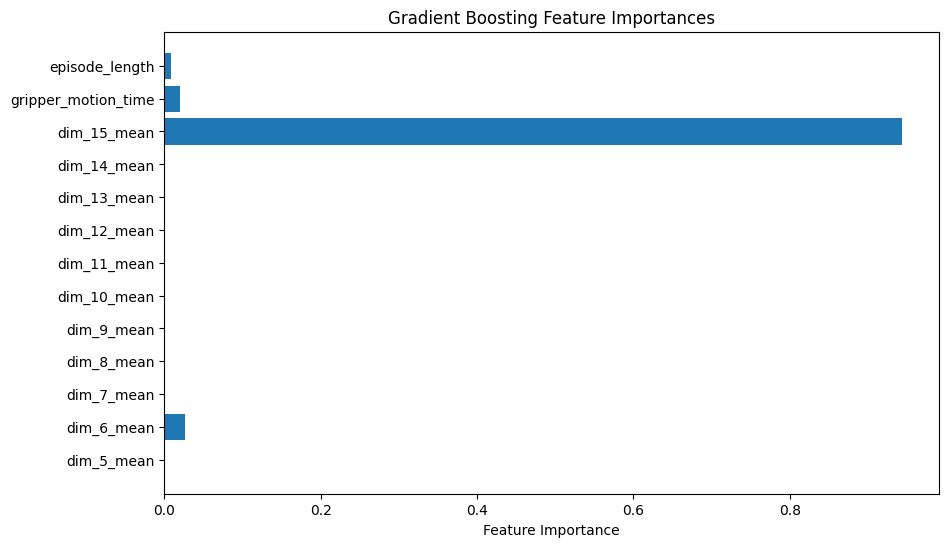

In [ ]:
import matplotlib.pyplot as plt
feature_importances = best_gb.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(X.columns, feature_importances)
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Feature Importances")
plt.show()

### Random Forest
Random Forest constructs many decision trees independently on random subsets of the data and features, then combines their predictions by  majority vote (classification) to improve stability and reduce overfitting.

Using a Random Forest Classifier for decision trees We obtained the following model.
Similarly to Gradient Boosting, we controlled overfitting by using shallow trees with maximum depth = 2.

In [ ]:


# Define the parameter grid
param_grid = {
    'n_estimators': [5,10,12,15,17,20],
    'max_depth': [2],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2'],  # Add randomness to reduce overfitting
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Grid search with 5-fold CV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

best_rf = grid_search.best_estimator_

# Cross-validation score of best model
cv_scores = cross_val_score(best_rf, X, y, cv=5)
print("Cross-Validation Accuracy:", cv_scores.mean())
print("CV scores:", cv_scores)

# Train-test split evaluation
#X_train, X_test, y_train, y_test = train_test_split(
 #   X, y, test_size=0.2, random_state=42, stratify=y)

best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
y_probs_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_probs_rf))

print("Best Parameters for Random Forest:")
print(grid_search.best_params_)

Cross-Validation Accuracy: 0.9740740740740741
CV scores: [0.99074074 0.98148148 1.         0.96296296 0.93518519]
Random Forest Results:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        55
           1       0.98      0.98      0.98        53

    accuracy                           0.98       108
   macro avg       0.98      0.98      0.98       108
weighted avg       0.98      0.98      0.98       108

Confusion Matrix:
[[54  1]
 [ 1 52]]
ROC AUC: 0.9993138936535163
Best Parameters for Random Forest:
{'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 20}


#### Random Forest Feature Importance
We can observe the feature randomness that characterizes the random forest method as opposed to Gradient Boosting for example.
This allows a better capture of the variance in the data.

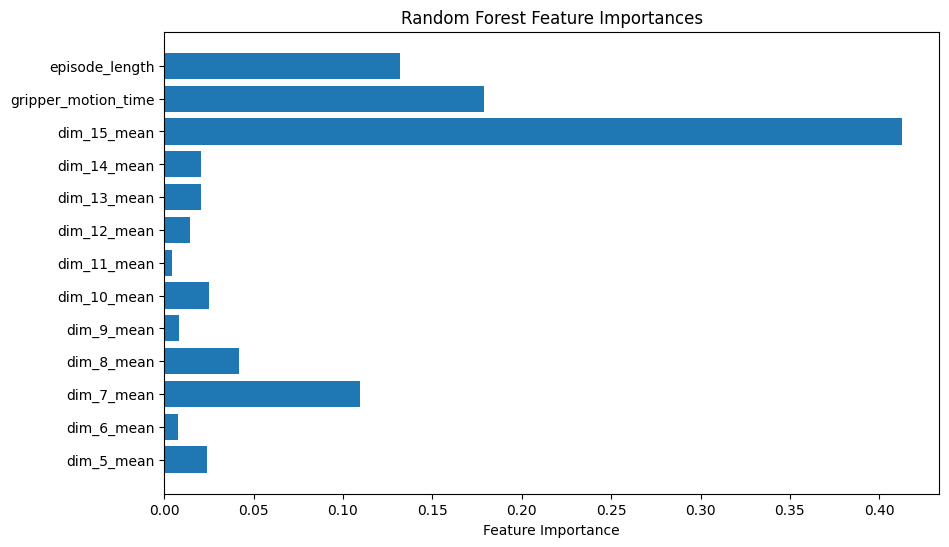

In [13]:
feature_importances = best_rf.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(X.columns, feature_importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

### Random Forest vs. Gradient Boosting - Test Errors vs. Number of Trees
The visualization corresponds with theory, as wee observe that Gradient Boosting has a higher tendency to overfitting and it stabilizes faster.
The plot also support the bias-variance trade off:
 -  GB: Lower bias, higher variance
 -  RF: Higher bias, lower variance

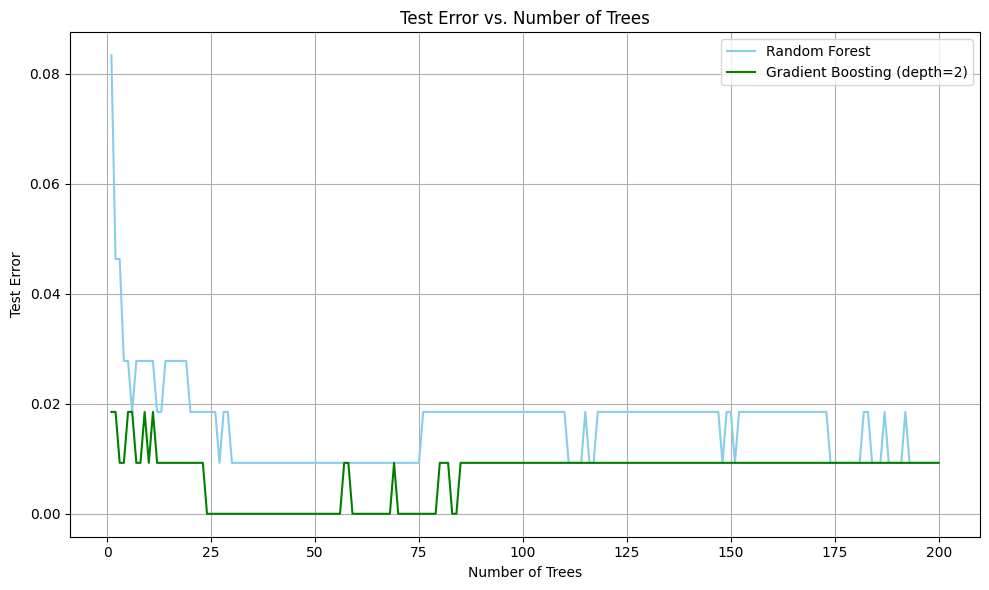

In [ ]:


# Example data (replace with your own X and y)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(
 #   X, y, test_size=0.2, stratify=y, random_state=42
#)

# Range of tree numbers
n_trees = list(range(1, 201))
rf_errors = []
gb_errors = []

# Loop through tree numbers
for n in n_trees:
    # Random Forest
    rf = RandomForestClassifier(n_estimators=n, max_depth=2, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_errors.append(zero_one_loss(y_test, rf_pred))

    # Gradient Boosting
    gb = GradientBoostingClassifier(    n_estimators=n,
    max_depth=2,
    learning_rate=0.02,
    min_samples_leaf=5,
    subsample=0.9,
    random_state=42)
    gb.fit(X_train, y_train)
    gb_pred = gb.predict(X_test)
    gb_errors.append(zero_one_loss(y_test, gb_pred))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_trees, rf_errors, label="Random Forest", color='skyblue')
plt.plot(n_trees, gb_errors, label="Gradient Boosting (depth=2)", color='green')
plt.xlabel("Number of Trees")
plt.ylabel("Test Error")
plt.title("Test Error vs. Number of Trees")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Support Vector Machines

Support Vector Machines (SVMs) are supervised learning models that seek the optimal hyperplane to separate classes by maximizing the margin between the closest data points of each class (support vectors). Linear SVMs are particularly useful when the data is linearly separable or nearly so.

Using a linear Kernel and balanced class weight we achieved a model with strong predictive performance.

In [7]:
# Define scoring
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

### 🔴 2. SVM (with CV)
# This is the model definition needed before plotting its coefficients
svm_model = SVC(kernel="linear", probability=True, class_weight="balanced", random_state=42)
svm_cv = cross_validate(svm_model, X_train, y_train, cv=5, scoring=scoring)

print("\n🔴 SVM Cross-Validation Results:")
for metric in scoring:
    print(f"{metric}: {svm_cv[f'test_{metric}'].mean():.4f}")

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

print("\n🔴 SVM (Test Set):")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("ROC AUC:", roc_auc_score(y_test, y_prob_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


🔴 SVM Cross-Validation Results:
accuracy: 0.9652
f1: 0.9648
roc_auc: 0.9909

🔴 SVM (Test Set):
Accuracy: 0.9629629629629629
F1 Score: 0.9615384615384616
ROC AUC: 0.9951972555746141
Confusion Matrix:
 [[54  1]
 [ 3 50]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        55
           1       0.98      0.94      0.96        53

    accuracy                           0.96       108
   macro avg       0.96      0.96      0.96       108
weighted avg       0.96      0.96      0.96       108



C:\Users\danar\AppData\Local\Temp\ipykernel_22656\3793760785.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=svm_importance, x='Importance', y='Feature', palette='Greens_d')


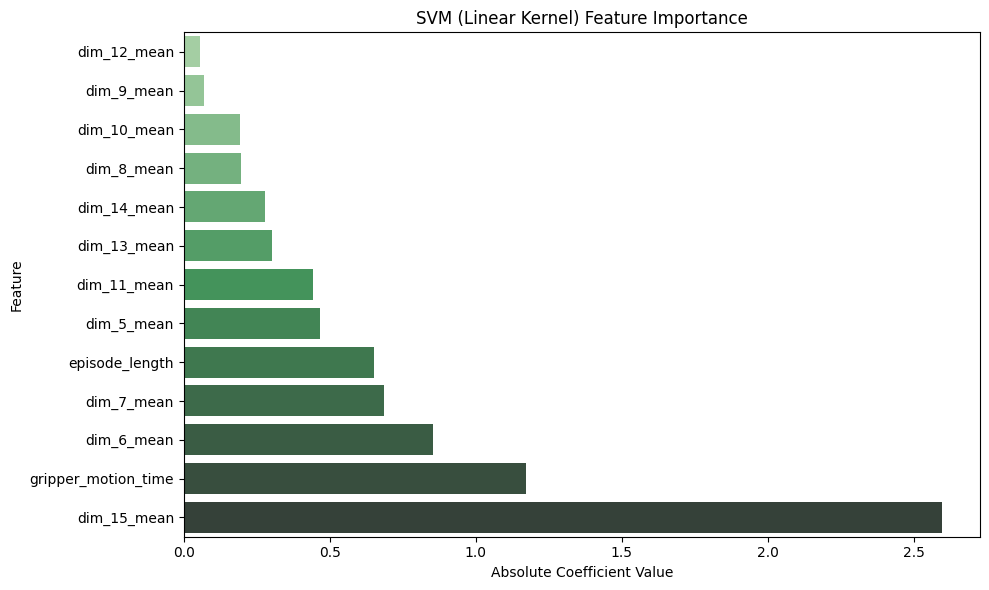

In [8]:
# Extract SVM coefficients (linear kernel returns one row per class)

# Assuming svm_model has been fitted in a previous cell
svm_coef = svm_model.coef_[0]  # For binary classification, take the 1D array

# Create DataFrame
svm_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(svm_coef)  # Use absolute value for magnitude
})

# Sort by importance
svm_importance = svm_importance.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=svm_importance, x='Importance', y='Feature', palette='Greens_d')
plt.title("SVM (Linear Kernel) Feature Importance")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()

### Sensitivity Analysis

All the models we trained demonstrated high accuracy and overall very good performance.
To examine the robustness of the different models, we conducted a sensitivity analysis.

Specifically, we trained 80 models with different train/test splits (changing the random seed each time) for Lasso, Stepwise AIC, Gradient Boosting, and Random Forest.

The results reassured us that each of the models is robust and not significantly affected by split randomness, with an average accuracy of approximately 97% and a standard deviation of around 0.015 across runs. 


Lasso

Mean Accuracy: 0.9667
Standard Deviation: 0.0153

Logistic Regression

Mean Accuracy: 0.9714
Standard Deviation: 0.0159

Gradient Boosting

Mean Accuracy: 0.9713
Standard Deviation: 0.0159

Random Forest

Mean Accuracy: 0.9700
Standard Deviation: 0.0152


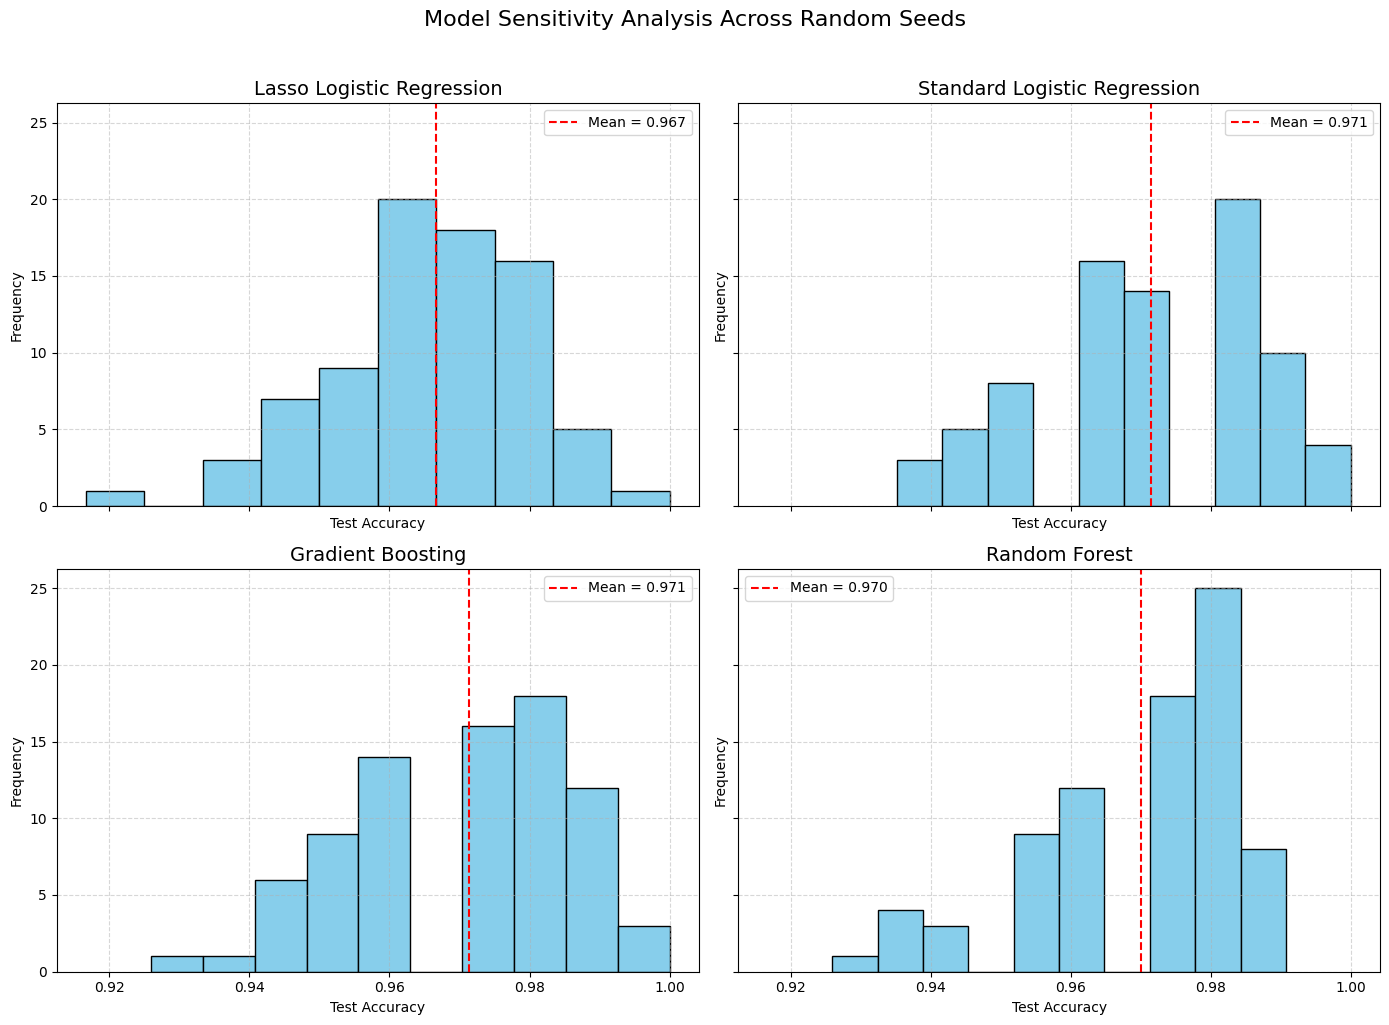

In [16]:
# Settings
seeds = list(range(80))  # seeds to vary splits
#Lasso
lasso_accuracies = []

for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=df_scaled["task"]
    )

    lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    lasso_accuracies.append(acc)

print(f"\nLasso")
print(f"\nMean Accuracy: {np.mean(lasso_accuracies):.4f}")
print(f"Standard Deviation: {np.std(lasso_accuracies):.4f}")

#LR
# Define your input and label subset
X_logreg = df_scaled[['dim_5_mean', 'dim_6_mean','dim_7_mean','dim_11_mean','dim_13_mean','dim_15_mean',
               'gripper_motion_time', 'episode_length']]
y_logreg = df_scaled['task_label']

logreg_accuracies = []

for seed in seeds:
    X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
        X_logreg, y_logreg, test_size=0.2, random_state=seed, stratify=y_logreg
    )

    model_lr = LogisticRegression(max_iter=1000)
    model_lr.fit(X_train_lr, y_train_lr)
    y_pred_lr = model_lr.predict(X_test_lr)
    logreg_accuracies.append(accuracy_score(y_test_lr, y_pred_lr))

print(f"\nLogistic Regression")
print(f"\nMean Accuracy: {np.mean(logreg_accuracies):.4f}")
print(f"Standard Deviation: {np.std(logreg_accuracies):.4f}")


#gb
gb_accuracies = []

for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=df_scaled["task"]
    )

    gb = GradientBoostingClassifier(n_estimators=10,
    max_depth=2,
    learning_rate=0.02,
    min_samples_leaf=5,
    subsample=0.9,
    random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    gb_accuracies.append(acc)

print(f"\nGradient Boosting")
print(f"\nMean Accuracy: {np.mean(gb_accuracies):.4f}")
print(f"Standard Deviation: {np.std(gb_accuracies):.4f}")

#rf
rf_accuracies = []

for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=df_scaled["task"]
    )

    rf = RandomForestClassifier(n_estimators=20, max_depth=2, random_state=seed)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rf_accuracies.append(acc)

print(f"\nRandom Forest")
print(f"\nMean Accuracy: {np.mean(rf_accuracies):.4f}")
print(f"Standard Deviation: {np.std(rf_accuracies):.4f}")

# Creating Histogram plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

titles = [
    "Lasso Logistic Regression",
    "Standard Logistic Regression",
    "Gradient Boosting",
    "Random Forest"
]

accuracy_lists = [
    lasso_accuracies,
    logreg_accuracies,
    gb_accuracies,
    rf_accuracies
]

for ax, acc, title in zip(axes, accuracy_lists, titles):
    ax.hist(acc, bins=10, edgecolor='black', color='skyblue')
    ax.axvline(np.mean(acc), color='red', linestyle='--', label=f"Mean = {np.mean(acc):.3f}")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Test Accuracy")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

plt.suptitle("Model Sensitivity Analysis Across Random Seeds", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Model Comparison 
-   Tree-based models slightly outperform in accuracy
-   Tree-based models have a higher tendency to overfitting
-   Lasso and AIC provide interpretability
-   SVM offers a balance of both
-   dim_15_mean consistently most important

### Conclusions
-   Feature Engineering findings correlated with the classification models
-   Model interpretability vs performance was demonstrated
-   Bias vs Variance trade off was demonstrated
-   Tree-based models need to be regulated for over-fitting
-   Test predictive power was slightly lower for 'place' tasks in most models (subtasks)
-   All models demonstrated robustness in sensitivity analysis with around 97% mean accuracy and 0.015 standard 
deviation 


